# Combine figure diseases MLR and Cox
## UNFINISHED

Last modification: 02/12/2022

In [222]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from statsmodels.formula.api import ols, logit
from datetime import datetime
import seaborn as sns

DATE = datetime.now().strftime("%Y-%m-%d")

In [223]:

file_info_name='pheno_info_main.csv'
pheno_info_file = '/SSD/home/sofia/retina-phenotypes/complementary/disease_association/'+str(file_info_name)
display_info=True
date='2022_11_23'
ventile='covar_fix'
output_dir ='/SSD/home/sofia/retina-phenotypes/complementary/disease_association/'

## Read Diseases
diseases_dir ='/NVME/decrypted/scratch/multitrait/UK_BIOBANK_PREPRINT/diseases_cov/'
## Read Cox
cox_file_name = str(diseases_dir) + str(date)+'_'+str(ventile)+'__cox_full_results.csv'
df_cox = pd.read_csv(cox_file_name, index_col=0) # columns needed  *_hr for hazard ratio, and *_pval

## Read phenos covar diseases for N cases
pheno_cov_diseases_file =diseases_dir+'2022_11_23_covar_fix_diseases_cov.csv'

In [224]:
## Read MLR
betas=pd.read_csv(diseases_dir+'reg_betas_.csv', index_col=0)
log10p=pd.read_csv(diseases_dir+'reg_log10p_.csv', index_col=0)
betas = betas.astype('float64') # in case betas was coded as object type

In [225]:
## Only select main phenotypes:
df_cox = pd.DataFrame(df_cox, index = list(betas.index))


In [226]:
## Separate in pval and hazar ratio dfs:
df_cox_pvalues= df_cox.loc[:,df_cox.columns.str.endswith('_pval')]
df_cox_hazar_ratio= df_cox.loc[:,df_cox.columns.str.endswith('_hr')]

In [227]:
df_cox_log10p= -np.log(df_cox_pvalues)

In [228]:
SUPPLEMENTARY_LABELS='tau1_all,tau1_artery,tau1_vein,ratio_AV_DF,tau2_all,tau2_artery,tau2_vein,tau4_all,tau4_artery,tau4_vein,D_std,D_A_std,D_V_std,D_CVMe,D_CVMe_A,D_CVMe_V,sd_mean_size,N_median_main_arteries,N_median_main_veins,arcLength_artery,arcLength_vein,bifurcations,VD_orig_all,VD_orig_artery,VD_orig_vein,ratio_VD,FD_all,FD_artery,FD_vein,mean_angle_taa,mean_angle_tva,eq_CRAE,eq_CRVE,median_CRAE,median_CRVE,CRAE,CRVE,ratio_CRAE_CRVE,ratio_median_CRAE_CRVE,ratio_standard_CRE,medianDiameter_all,medianDiameter_artery,medianDiameter_vein,ratio_AV_medianDiameter'
SUPPLEMENTARY_NAMES='tortuosity,A tortuosity,V tortuosity,ratio tortuosity,tortuosity2,A tortuosity2,V tortuosity2,tortuosity3,A tortuosity3,V tortuosity3,std diameter,A std diameter,V std diameter,CVMe diameter,A CVMe diameter,V CVMe diameter,std norm diameter,A num main,V num main,A arc length,V arc length,bifurcations,vascular density,A vascular density,V vascular density,ratio vascular density,fractal dimension,A fractal dimension,V fractal dimension,A temporal angle,V temporal angle,A central retinal eq,V central retinal eq,A main diameter,V main diameter,A central retinal eq2,V central retinal eq2,ratio central retinal eq,ratio main diameter,ratio central retinal eq2,median diameter,A median diameter,V median diameter,ratio median diameter'

##### MAIN PHENOTYPES
MAIN_LABELS='mean_angle_taa,mean_angle_tva,tau1_vein,tau1_artery,ratio_AV_DF,eq_CRAE,ratio_CRAE_CRVE,D_A_std,D_V_std,eq_CRVE,ratio_VD,VD_orig_artery,bifurcations,VD_orig_vein,medianDiameter_artery,medianDiameter_vein,ratio_AV_medianDiameter'
MAIN_NAMES='A temporal angle,V temporal angle,V tortuosity,A tortuosity,ratio tortuosity,A central retinal eq,ratio central retinal eq,A std diameter,V std diameter,V central retinal eq,ratio vascular density,A vascular density,bifurcations,V vascular density,A median diameter,V median diameter,ratio median diameter'
type_used= 'main' #sup

if type_used=='main':
    old = MAIN_LABELS
    new = MAIN_NAMES
elif type_used=='sup':
    old = SUPPLEMENTARY_LABELS
    new = SUPPLEMENTARY_NAMES

list_old_phenotypes=list(old.split(","))
list_new_phenotypes=list(new.split(","))

if type_used == 'main':
    file_info_name='pheno_info_main.csv'
    file_info_cox='pheno_info_cox.csv'
    
elif type_used == 'suplementary':
    file_info_name='pheno_info_sup.csv'
    file_info_cox='pheno_info_cox.csv'

else:
    print('Error, should be main or suplementary!')
    #sys.stop()

inf = pd.read_csv(pheno_info_file)
list_diseases = inf['name'].values
list_diseases_new = inf['final_name'].values

cox_names = pd.read_csv(file_info_cox)
list_diseases_cox = cox_names['name'].values
list_diseases_cox_new = cox_names['final_name'].values
list_diseases_cox_original= cox_names['original_name'].values
    

In [229]:
print(list(df_cox_log10p.index),list_old_phenotypes)

['mean_angle_taa', 'mean_angle_tva', 'tau1_vein', 'tau1_artery', 'ratio_AV_DF', 'eq_CRAE', 'ratio_CRAE_CRVE', 'D_A_std', 'D_V_std', 'eq_CRVE', 'ratio_VD', 'VD_orig_artery', 'bifurcations', 'VD_orig_vein', 'medianDiameter_artery', 'medianDiameter_vein', 'ratio_AV_medianDiameter'] ['mean_angle_taa', 'mean_angle_tva', 'tau1_vein', 'tau1_artery', 'ratio_AV_DF', 'eq_CRAE', 'ratio_CRAE_CRVE', 'D_A_std', 'D_V_std', 'eq_CRVE', 'ratio_VD', 'VD_orig_artery', 'bifurcations', 'VD_orig_vein', 'medianDiameter_artery', 'medianDiameter_vein', 'ratio_AV_medianDiameter']


In [230]:
##Change the name of the columns and index in beta and log10:
def filter_rename_col_index(df_, l_pehos_old, l_phenos_new, l_diseases_old, l_diseases_new,):
    df_ =df_.loc[l_pehos_old]
    df_.rename(index=dict(zip(l_pehos_old, l_phenos_new)), inplace=True)
    #print(df_)
    df_.rename(columns=dict(zip(l_diseases_old, l_diseases_new)), inplace=True)
    return df_

df_cox_log10p = filter_rename_col_index(df_cox_log10p, list_old_phenotypes, list_new_phenotypes, list_diseases, list_diseases_new)
log10p = filter_rename_col_index(log10p, list_old_phenotypes, list_new_phenotypes, list_diseases, list_diseases_new)
betas = filter_rename_col_index(betas, list_old_phenotypes, list_new_phenotypes, list_diseases, list_diseases_new)
df_cox_hazar_ratio = filter_rename_col_index(df_cox_hazar_ratio, list_old_phenotypes, list_new_phenotypes, list_diseases_cox, list_diseases_cox_new)

print(len(df_cox_log10p), len(log10p), len(betas) )

17 17 17


In [231]:
list_diseases_cox

array(['age_diabetes_hr', 'age_angina_hr', 'age_heartattack_hr',
       'age_DVT_hr', 'age_stroke_hr', 'age_glaucoma_hr',
       'age_cataract_hr', 'age_other_serious_eye_condition_hr',
       'age_pulmonary_embolism_hr', 'age_death_hr'], dtype=object)

[Text(0.5, 0, 'Diabetes'),
 Text(1.5, 0, 'Angina'),
 Text(2.5, 0, 'Heart attack'),
 Text(3.5, 0, 'DVT'),
 Text(4.5, 0, 'Sroke'),
 Text(5.5, 0, 'Glaucoma'),
 Text(6.5, 0, 'Cataract'),
 Text(7.5, 0, 'Other eye diseases'),
 Text(8.5, 0, 'Pulmonary embolism'),
 Text(9.5, 0, 'Mortality')]

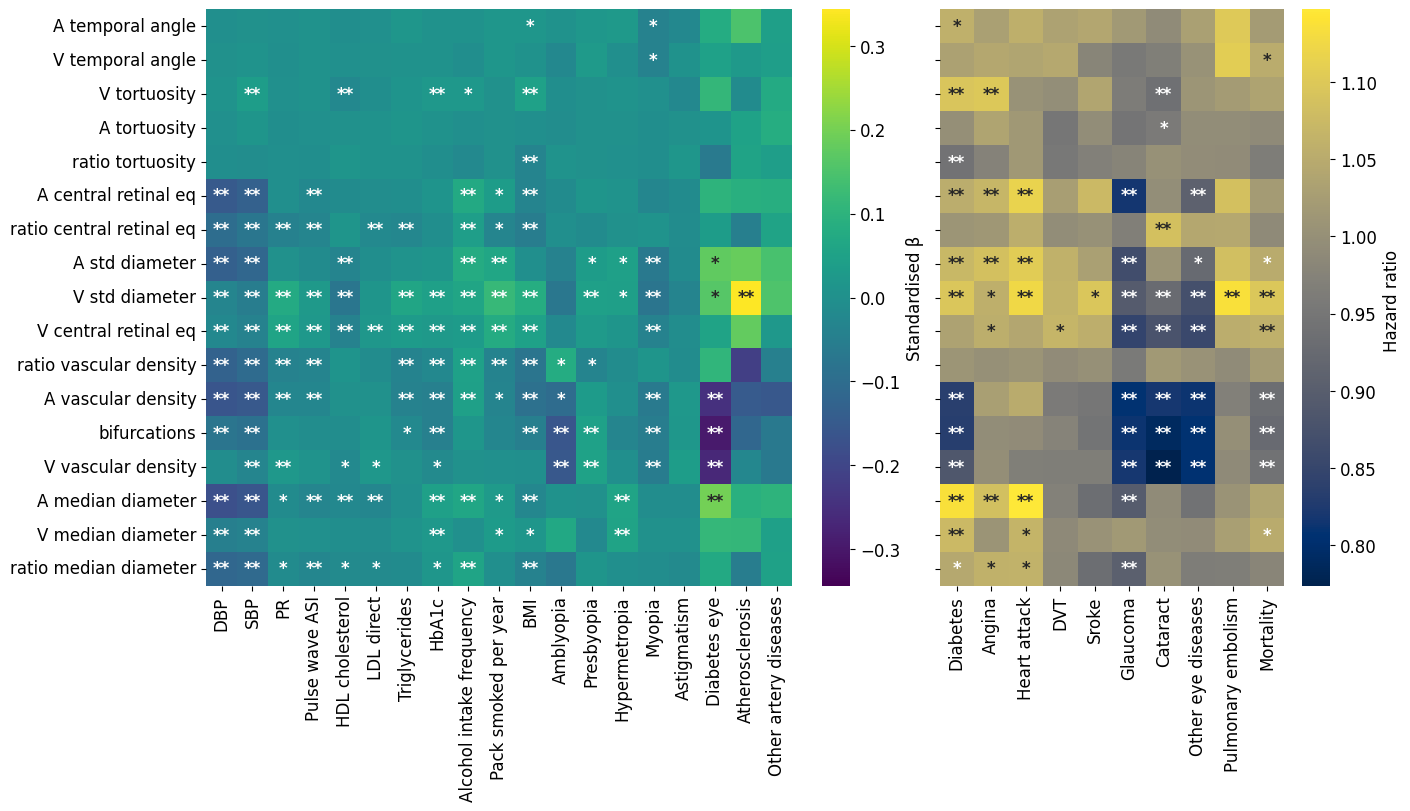

In [265]:
figsize_val=(14, 8)
## This colours by beta and annotates Bonferroni-significant models with an asterisk
###MLR
Bonf_thresh = -np.log10(0.05 / (log10p.shape[0] * log10p.shape[1]))
Bonf_thresh2 = -np.log10(0.001 / (log10p.shape[0] * log10p.shape[1]))

log10p_copy = log10p.copy()
log10p_copy2 = log10p.copy()
log10p_copy3 = log10p.copy()

log10p_copy= (log10p_copy>Bonf_thresh).replace({True:'*', False:''})
log10p_copy2= (log10p_copy2>Bonf_thresh2).replace({True:'*', False:''})
log10p_copy3 =log10p_copy+log10p_copy2

###COX
log10p_copy_cox = df_cox_log10p.copy()
log10p_copy2_cox = df_cox_log10p.copy()
log10p_copy3_cox = df_cox_log10p.copy()

log10p_copy_cox= (log10p_copy_cox>Bonf_thresh).replace({True:'*', False:''})
log10p_copy2_cox= (log10p_copy2_cox>Bonf_thresh2).replace({True:'*', False:''})
log10p_copy3_cox =log10p_copy_cox+log10p_copy2_cox


#img1 = mpimg.imread('2022-10-19_MLR_ventile5.jpg')
#img2 = mpimg.imread('2022-10-19_MLR_ventile5.jpg')

fig, (ax1, ax2) = plt.subplots(1,2, sharey=True, figsize=figsize_val, gridspec_kw={'width_ratios': [1.7, 1]})
#gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1]) 
plt.rcParams['figure.constrained_layout.use'] = True
#ax1.yaxis.set_ticks_position('right')
plt.rcParams['font.size'] = '12'
fig1 = sns.heatmap(betas, 
            annot=log10p_copy3, #(log10p>Bonf_thresh).replace({True:'*', False:''}), 
            cbar=True, #If not False
            fmt="", annot_kws={'weight': 'bold'}, 
            vmin=-abs(betas).max().max(), 
            vmax=abs(betas).max().max(), 
            cmap='viridis',alpha=1.0, cbar_kws={'label': 'Standardised \u03B2'},
               ax=ax1)
fig1.set_xticklabels(ax1.get_xticklabels(), rotation = 90)

########### TO DO: change this figure by COX FIGURE
#ax2.yaxis.set_ticks_position('right')
fig2 = sns.heatmap(df_cox_hazar_ratio, 
            annot=log10p_copy3_cox, #(log10p>Bonf_thresh).replace({True:'*', False:''}), 
            cbar=True, #False
            fmt="", annot_kws={'weight': 'bold'}, 
            vmin=(df_cox_hazar_ratio).min().min(), 
            vmax=(df_cox_hazar_ratio).max().max(), 
            cmap='cividis', alpha=1.0, cbar_kws={'label': 'Hazard ratio '},
               ax=ax2)
fig2.set_xticklabels(ax2.get_xticklabels(), rotation = 90)


### cases and controls

In [233]:
date2='2022-11-22'
N_cases_file_name = str(diseases_dir) + str(date2)+'_N_CASES_MLR_.csv' #2022-11-22_N_CASES_MLR_.csv
print(N_cases_file_name)
#df_pheno_dise =pd.read_csv(N_cases_file_name)
#df_pheno_dise

/NVME/decrypted/scratch/multitrait/UK_BIOBANK_PREPRINT/diseases_cov/2022-11-22_N_CASES_MLR_.csv


In [238]:
df_pheno_dis_cov = pd.read_csv(pheno_cov_diseases_file)

list_all_old = list(list_diseases) + list(list_diseases_cox_original) #+ list_old_phenotypes
list_all_new = list(list_diseases_new) + list(list_diseases_cox_new) #+ list_new_phenotypes

#filter
df_pheno_dis_cov_MLR = df_pheno_dis_cov[list_all_old]

#print(df_pheno_dis_cov_MLR)
def filter_rename_col(df_,list_all_old, list_all_new,):
    df_.rename(columns=dict(zip(list_all_old, list_all_new)), inplace=True)
    #print(df_)
    return df_

df_pheno_dis_cov_MLR = filter_rename_col(df_pheno_dis_cov_MLR.copy(), list_all_old, list_all_new)
#print(df_pheno_dis_cov_MLR)
#df_pheno_dis_cov_MLR=df_pheno_dis_cov[list_diseases]

list_value=[]

for col in df_pheno_dis_cov_MLR.columns:
    print(col, df_pheno_dis_cov_MLR[col].notnull().sum())
    data={
         'disease': col,
         'N': df_pheno_dis_cov_MLR[col].notnull().sum()
     }
    list_value.append(data)
df_count_val = pd.DataFrame(list_value)
    #print(col, df_pheno_dis_cov_MLR[col].value_counts())
    #if col in list_binary:
    #    print(col, df_pheno_dis_cov_MLR[col].value_counts())

#df_pheno_dis_cov_MLR['Atherosclerosis']


DBP 68588
SBP 68588
PR 68588
Pulse wave ASI 68170
HDL cholesterol 59853
LDL direct 63492
Triglycerides 63550
HbA1c 61130
Alcohol intake frequency 68690
Pack smoked per year 19214
BMI 68543
Amblyopia 2263
Presbyopia 26065
Hypermetropia 12261
Myopia 24658
Astigmatism 8143
Diabetes eye 640
Atherosclerosis 459
Other artery diseases 412
Diabetes 3320
Angina 1832
Heart attack 1361
DVT 1307
Sroke 969
Glaucoma 1181
Cataract 3452
Other eye diseases 1254
Pulmonary embolism 514
Mortality 4151


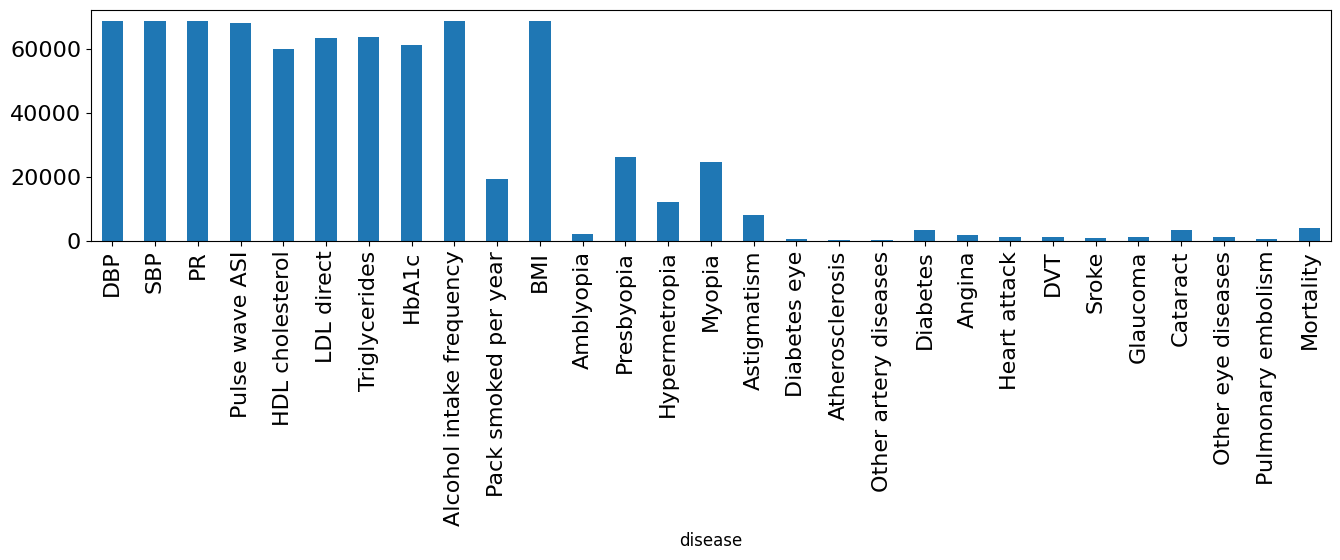

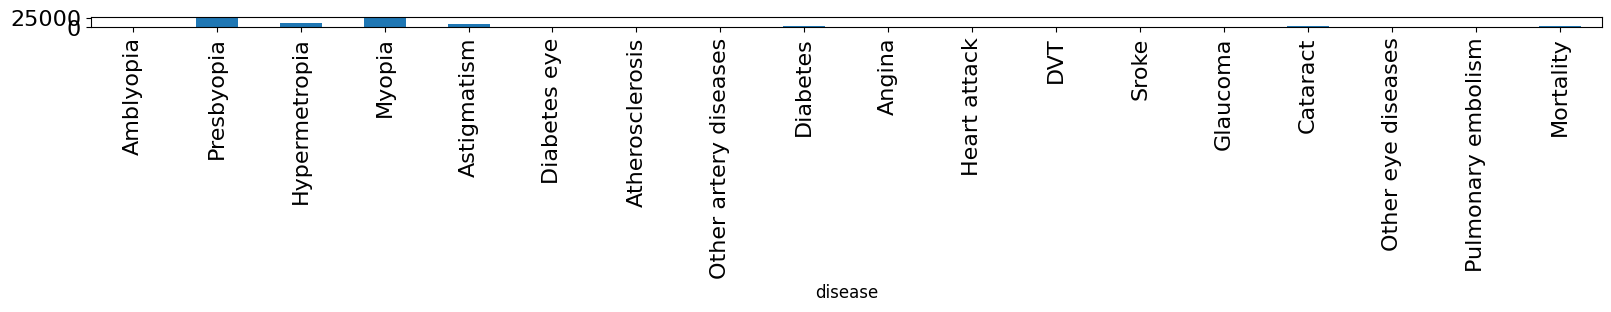

In [267]:
def bar_plot(df_used, title_name, set_index_column):
    #ax= df_N_cases.plot()
    #ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.5),fancybox=True, shadow=True, ncol=5)
    ax = df_used.set_index(set_index_column).plot.bar(rot=90,  figsize=figsize_val_2, fontsize=16)
    ax.get_legend().remove()
    #ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.5),fancybox=True, shadow=True, ncol=5)
    #plt.savefig(save_files+str(title_name)+'.pdf', facecolor='white', bbox_inches='tight', pad_inches=0.1, dpi=150)

list_cases_controls = [ 'Amblyopia',
 'Presbyopia',
 'Hypermetropia',
 'Myopia',
 'Astigmatism',
 'Diabetes eye',
 'Atherosclerosis',
 'Other artery diseases',
 'Diabetes',
 'Angina',
 'Heart attack',
 'DVT',
 'Sroke',
 'Glaucoma',
 'Cataract',
 'Other eye diseases',
 'Pulmonary embolism',
 'Mortality']

figsize_val_2=(16,3)
#plt.rcParams['font.size'] = '12'
bar_plot(df_count_val, 'Number of cases', 'disease')
df_count_val_binary=df_count_val[df_count_val['disease'].isin(list_cases_controls)]
bar_plot(df_count_val_binary, 'Number of cases', 'disease')


#df_count_val = df_count_val.T
#df_count_val.to_csv(output_dir+ str(DATE)+'N_CASES_MLR_'+ventile+'.csv', sep=',', index=False)